# **News classification using RNNs and LSTM**
SAARANG ARORA

Classification of news is something that we see prevalent in our daily lives. from newspapers having different pages for different types of news to modern browsers like Edge sorting news on its homepage. classification is sueful so that those who are reading the news can easily access the topic of their interest. be it entertainment news or economic. They need not go through the titles of each and every news article in order to gauge their interest in the topic, and th enews item itself.

Nowadays, due to the overwhelming amount of news, it is hard to manually classify these news articles, and a simple heurestical based keyword search is quite out of the picture due to the interconnectedness of the world nowadays. So, what is the solution? 

**AI**

Okay, that is a bit much but yes, it is AI, or atleast text classification techniques. Techniques such as TFIDF, BOW, and such are pretty decent at classification and basic sentiment analysis, but they often lose contextual clues, clues that are often important to the process of classification itself. so steps in what we are going to focus on today. **RNNs and LSTMs**

### What are RNNs and LSTMs?
**RNN**, or Recurrent Neural Network, is a type of Neural Network where the output from the previous step is fed as input to the current step. so basically, they help preserve the sequential order of words, which if you haven't niticed is pretty important in language. Not paying heed to it would be like putting the horse before the cart- no, it would be like the cart bef- no... *ANYWAYS*, SEQUENCE IS IMPORTANT!

**LSTM**, or Long-Short Term Memory, is a type of recurrent neural network but is better than traditional recurrent neural networks in terms of memory. Having a good hold over memorizing certain patterns LSTMs perform fairly better. They are also better at remembering contexts across a large corpus of texts than traditional RNNs, which are more localized.

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv("/kaggle/input/labeled-newscatcher-dataaset/labeled_newscatcher_dataset.csv", delimiter=";")
df.head()

,topic,link,domain,published_date,title,lang
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,en
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study,en
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...,en


## Data Exploration

In [8]:
df.describe()

,topic,link,domain,published_date,title,lang
count,108774,108774,108774,108774,108774,108774
unique,8,106130,5164,68743,103180,1
top,TECHNOLOGY,https://www.google.com/,dailymail.co.uk,2020-08-04 01:00:00,"US tops 5 million confirmed virus cases, to Eu...",en
freq,15000,19,1855,41,21,108774


from this, we can see at a glance that there is only one language, and that is english. So, we will drop that column. Additionally, the link will also not be very helpful to us in terms of classification of the topics; we will drop the link column as well. We will also drop the published date column.

I have kept the domain name as there are some domains that particularly deal with specific news, like EurekaAlert, which is a website that will have high cosine relation with SCIENCE topic.

In [9]:
df["topic"].unique()

array(['SCIENCE', 'TECHNOLOGY', 'HEALTH', 'WORLD', 'ENTERTAINMENT',
       'SPORTS', 'BUSINESS', 'NATION'], dtype=object)

In [10]:
df["domain"].unique()

array(['eurekalert.org', 'pulse.ng', 'express.co.uk', ...,
       'intothecalderon.com', 'the-daily-record.com',
       'ghanabusinessnews.com'], dtype=object)

In [11]:
df = df.drop(["link", "lang", "published_date"], axis=1)
# df = df.drop(df["lang"])
df

,topic,domain,title
0,SCIENCE,eurekalert.org,A closer look at water-splitting's solar fuel ...
1,SCIENCE,pulse.ng,"An irresistible scent makes locusts swarm, stu..."
2,SCIENCE,express.co.uk,Artificial intelligence warning: AI will know ...
3,SCIENCE,ndtv.com,Glaciers Could Have Sculpted Mars Valleys: Study
4,SCIENCE,thesun.ie,Perseid meteor shower 2020: What time and how ...
...,...,...,...
108769,NATION,vanguardngr.com,PDP governors’ forum urges security agencies t...
108770,BUSINESS,patentlyapple.com,"In Q2-20, Apple Dominated the Premium Smartpho..."
108771,HEALTH,belfastlive.co.uk,Coronavirus Northern Ireland: Full breakdown s...
108772,ENTERTAINMENT,thenews.com.pk,Paul McCartney details post-Beatles distress a...


Now, I will add the domain name to the end of the title so that we can get a single string out of the title and the domain name.

In [12]:
df["title_domain"] = df["title"] + " " + df["domain"]
df = df.drop(["title", "domain"], axis=1)

In [13]:
df["title_domain"][2]

'Artificial intelligence warning: AI will know us better than we know ourselves express.co.uk'

Now that we just have the textual data, we will need start with the pre-processing of the data in order to feed it into the models.

## Model Pre-Processing
for NLP, the typical pre-processing steps that we will follow are the following - 
1. Dropping special characters
2. Dropping Stop words
3. Tokenization
4. Lemmatization/Stemming (we will go with lemmatization for reasons later explained)


Defining a funtion that will be useful to perform the functions in a modularized fashion.

In [15]:
def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text
    tokenize = SpaceTokenizer()
    tokens = tokenize.tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # # Lemmatize the tokens
    # lemmatizer = WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [16]:
df['preprocessed_title_domain'] = df['title_domain'].apply(preprocess_text)

# Show a sample of original and preprocessed text
print("Sample of original and preprocessed text:")
sample_df = pd.DataFrame({
    'Original': df['title_domain'][:5],
    'Preprocessed': df['preprocessed_title_domain'][:5]
})
print(sample_df)

Sample of original and preprocessed text:
                                            Original  \
0  A closer look at water-splitting's solar fuel ...   
1  An irresistible scent makes locusts swarm, stu...   
2  Artificial intelligence warning: AI will know ...   
3  Glaciers Could Have Sculpted Mars Valleys: Stu...   
4  Perseid meteor shower 2020: What time and how ...   

                                        Preprocessed  
0  closer look watersplittings solar fuel potenti...  
1  irresistible scent makes locusts swarm study f...  
2  artificial intelligence warning ai know us bet...  
3  glaciers could sculpted mars valleys study ndt...  
4  perseid meteor shower  time see huge bright fi...  


In [17]:
df

,topic,title_domain,preprocessed_title_domain
0,SCIENCE,A closer look at water-splitting's solar fuel ...,closer look watersplittings solar fuel potenti...
1,SCIENCE,"An irresistible scent makes locusts swarm, stu...",irresistible scent makes locusts swarm study f...
2,SCIENCE,Artificial intelligence warning: AI will know ...,artificial intelligence warning ai know us bet...
3,SCIENCE,Glaciers Could Have Sculpted Mars Valleys: Stu...,glaciers could sculpted mars valleys study ndt...
4,SCIENCE,Perseid meteor shower 2020: What time and how ...,perseid meteor shower time see huge bright fi...
...,...,...,...
108769,NATION,PDP governors’ forum urges security agencies t...,pdp governors forum urges security agencies re...
108770,BUSINESS,"In Q2-20, Apple Dominated the Premium Smartpho...",q apple dominated premium smartphone segment i...
108771,HEALTH,Coronavirus Northern Ireland: Full breakdown s...,coronavirus northern ireland full breakdown sh...
108772,ENTERTAINMENT,Paul McCartney details post-Beatles distress a...,paul mccartney details postbeatles distress bl...


In [18]:
from statistics import mean

def analyze_text_lengths(df, column_name):
    # Convert texts to list of tokens and calculate lengths
    text_lengths = df[column_name].apply(lambda x: len(x.split()))
    
    # Calculate statistics
    shortest_len = text_lengths.min()
    longest_len = text_lengths.max()
    avg_len = text_lengths.mean()
    
    # Get examples of shortest and longest texts
    shortest_text = df.loc[text_lengths.idxmin(), column_name]
    longest_text = df.loc[text_lengths.idxmax(), column_name]

    
    return {
        'shortest_length': shortest_len,
        'longest_length': longest_len,
        'average_length': avg_len,
        'shortest_text': shortest_text,
        'longest_text': longest_text,
        }

# Analyze the lengths
stats = analyze_text_lengths(df, 'preprocessed_title_domain')
stats

{'shortest_length': 2,
 'longest_length': 37,
 'average_length': 9.352896831963522,
 'shortest_text': 'expired thurrottcom',
 'longest_text': 'coronavirus australia live updates august   new covid cases  deaths victoria nz ready worst case scenario probe virus arrived freight trump says us economy strong calls us schools reopen epidemiologist says melbourne past peak  breaking news today newscomau'}

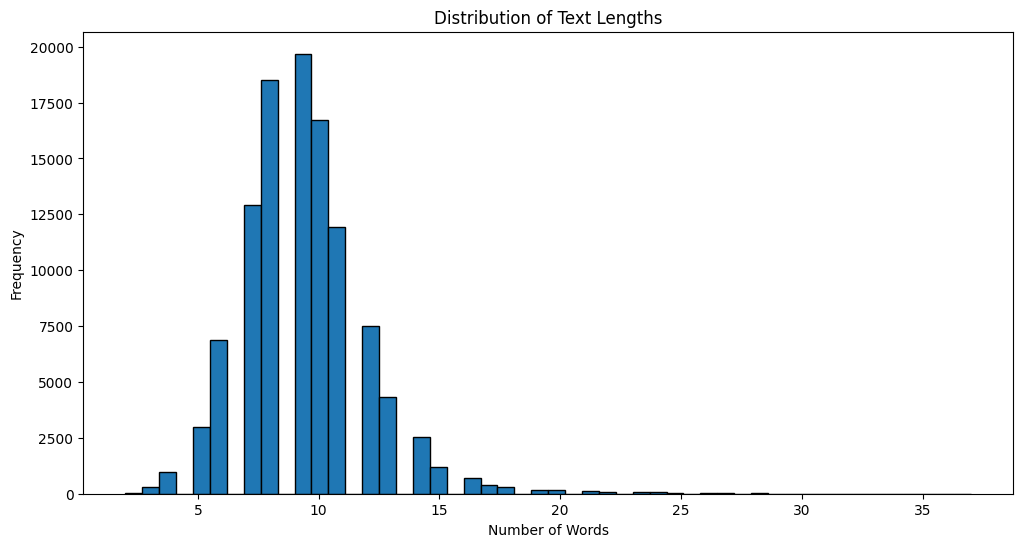


Recommended average length for padding: 9.352896831963522


In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(df['preprocessed_title_domain'].apply(lambda x: len(x.split())), 
         bins=50, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Save length statistics for later use in padding/truncating
max_length = stats['longest_length']
print(f"\nRecommended average length for padding: {stats['average_length']}")

as we can see, the average length of the texts is 9.35; taking a number around that will be appropriate. so I will select a input length of 12 so that accomodates some titles of higher number of words as well (as seen in the diagram.)

## Data Preperation

Now that we have pre-processed the data, we are going to prepare teh data so that it can be inputted into RNNs and LSTMs. for this, we have to make word embeddings, basically convert each word into a vector and then embed them in relation to each other in a vactor space.

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

## text preprocessing modules
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec

### Word Embedding

In [21]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

def create_word_embeddings(df, text_column, label_column, max_length=12, vocab_size=65000):
    """
    Create word embeddings and encode labels for RNN processing.
    
    Args:
        df (pandas.DataFrame): Input dataframe
        text_column (str): Name of the column containing preprocessed text
        label_column (str): Name of the column containing labels
        max_length (int): Maximum length of sequences
        vocab_size (int): Maximum number of words to keep
    
    Returns:
        tuple: (padded_sequences, encoded_labels, tokenizer, label_encoder)
    """
    # Initialize the tokenizer
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='UNK')
    
    # Fit the tokenizer on the texts
    tokenizer.fit_on_texts(df[text_column])
    
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(df[text_column])
    
    # Pad sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences, 
                                   maxlen=max_length,
                                   padding='post',
                                   truncating='post')
    
    # Encode the labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(df[label_column])
    
    # Get vocabulary information
    word_index = tokenizer.word_index
    vocab_size = min(len(word_index) + 1, vocab_size)
    
    return {
        'padded_sequences': padded_sequences,
        'encoded_labels': encoded_labels,
        'tokenizer': tokenizer,
        'label_encoder': label_encoder,
        'vocab_size': vocab_size,
        'word_index': word_index
    }

# Create the embeddings
embedding_data = create_word_embeddings(
    df,
    text_column='preprocessed_title_domain',
    label_column='topic',
    max_length=12,
    vocab_size=65000
)

# Print some useful information about the embeddings
print("\nVocabulary Statistics:")
print(f"Total unique words: {len(embedding_data['word_index'])}")
print(f"Vocabulary size used: {embedding_data['vocab_size']}")

# Show shape of the padded sequences
print("\nSequence Information:")
print(f"Shape of padded sequences: {embedding_data['padded_sequences'].shape}")
print(f"Number of classes: {len(np.unique(embedding_data['encoded_labels']))}")

# Show a sample of the padded sequences
print("\nSample of padded sequences:")
print(embedding_data['padded_sequences'][:2])

# Show how some text got converted to sequences
sample_texts = df['preprocessed_title_domain'][:2]
print("\nExample of text to sequence conversion:")
for text in sample_texts:
    print(f"\nOriginal text: {text}")
    sequence = embedding_data['tokenizer'].texts_to_sequences([text])[0]
    padded = pad_sequences([sequence], maxlen=12, padding='post', truncating='post')
    print(f"Sequence: {sequence}")
    print(f"Padded sequence: {padded[0]}")

# Save the tokenizer and label encoder for later use
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(embedding_data['tokenizer'], f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(embedding_data['label_encoder'], f)


Vocabulary Statistics:
Total unique words: 64845
Vocabulary size used: 64846

Sequence Information:
Shape of padded sequences: (108774, 12)
Number of classes: 8

Sample of padded sequences:
[[ 1773   238 27921  1504  1015   372   337     0     0     0     0     0]
 [12658  7733   205  8330  8014    20   210  4108     0     0     0     0]]

Example of text to sequence conversion:

Original text: closer look watersplittings solar fuel potential eurekalertorg
Sequence: [1773, 238, 27921, 1504, 1015, 372, 337]
Padded sequence: [ 1773   238 27921  1504  1015   372   337     0     0     0     0     0]

Original text: irresistible scent makes locusts swarm study finds pulseng
Sequence: [12658, 7733, 205, 8330, 8014, 20, 210, 4108]
Padded sequence: [12658  7733   205  8330  8014    20   210  4108     0     0     0     0]


In [22]:
len(embedding_data['tokenizer'].word_index)

64845

### Stratifying and splitting Train & Test data


Data Split Information:
Training set size: 87019 sequences
Test set size: 21755 sequences

Class Distribution Comparison:
               Overall   Train    Test
BUSINESS        0.1379  0.1379  0.1379
ENTERTAINMENT   0.1379  0.1379  0.1379
HEALTH          0.1379  0.1379  0.1379
NATION          0.1379  0.1379  0.1379
SCIENCE         0.0347  0.0347  0.0347
SPORTS          0.1379  0.1379  0.1379
TECHNOLOGY      0.1379  0.1379  0.1379
WORLD           0.1379  0.1379  0.1379


<Figure size 1200x600 with 0 Axes>

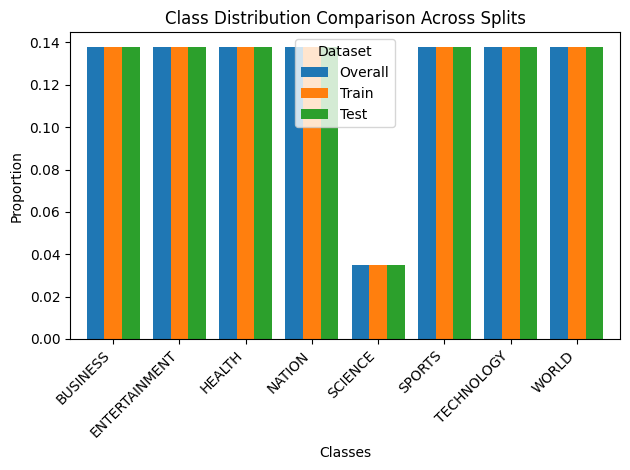


Verification Metrics:
Maximum distribution difference between train and test: 0.0000

Final Dataset Shapes:
X_train shape: (87019, 12)
X_test shape: (21755, 12)
y_train shape: (87019,)
y_test shape: (21755,)


In [24]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_stratified_split(X, y, test_size=0.2, random_state=42):
    """
    Create a stratified split of the data and verify class distributions.
    
    Args:
        X: Features (padded sequences)
        y: Labels (encoded)
        test_size: Proportion of test set
        random_state: Random seed for reproducibility
    
    Returns:
        tuple: (X_train, X_test, y_train, y_test, split_info)
    """
    # Perform stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Calculate class distributions
    train_dist = np.bincount(y_train) / len(y_train)
    test_dist = np.bincount(y_test) / len(y_test)
    overall_dist = np.bincount(y) / len(y)
    
    # Create distribution summary
    split_info = {
        'train_size': len(y_train),
        'test_size': len(y_test),
        'train_distribution': train_dist,
        'test_distribution': test_dist,
        'overall_distribution': overall_dist
    }
    
    return X_train, X_test, y_train, y_test, split_info

# Get the data from previous embedding step
X = embedding_data['padded_sequences']
y = embedding_data['encoded_labels']

# Create the stratified split
X_train, X_test, y_train, y_test, split_info = create_stratified_split(X, y)

# Print split information
print("\nData Split Information:")
print(f"Training set size: {split_info['train_size']} sequences")
print(f"Test set size: {split_info['test_size']} sequences")

# Get class names from label encoder
class_names = embedding_data['label_encoder'].classes_

# Create DataFrame for distribution comparison
dist_df = pd.DataFrame({
    'Overall': split_info['overall_distribution'],
    'Train': split_info['train_distribution'],
    'Test': split_info['test_distribution']
}, index=class_names)

print("\nClass Distribution Comparison:")
print(dist_df.round(4))

# Visualize class distributions
plt.figure(figsize=(12, 6))
dist_df.plot(kind='bar', width=0.8)
plt.title('Class Distribution Comparison Across Splits')
plt.xlabel('Classes')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Calculate and display verification metrics
print("\nVerification Metrics:")
train_test_diff = np.abs(split_info['train_distribution'] - split_info['test_distribution'])
max_diff = train_test_diff.max()
print(f"Maximum distribution difference between train and test: {max_diff:.4f}")

# Save split datasets
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

# Return the shapes of the resulting datasets
print("\nFinal Dataset Shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Here we see that the Science set has a lower distribution, and that is due to the fact that while all the other topics have 15K entries each, Science has a lower amount of entries. Due to that, we have chosen to stratify the data.

## **Model Building**

### **RNN (1 and 3 layer)**

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_single_layer_rnn(vocab_size, embedding_dim=100, input_length=12, num_classes=8):
    """
    Create a single-layer RNN model.
    
    Args:
        vocab_size: Size of the vocabulary
        embedding_dim: Dimension of word embeddings
        input_length: Length of input sequences
        num_classes: Number of output classes
    """
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size,
                 output_dim=embedding_dim,
                 input_length=input_length),
        
        # Single RNN layer
        SimpleRNN(units=128,
                 activation='tanh',
                 dropout=0.3,
                 recurrent_dropout=0.2),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

def create_three_layer_rnn(vocab_size, embedding_dim=100, input_length=12, num_classes=8):
    """
    Create a three-layer RNN model.
    
    Args:
        vocab_size: Size of the vocabulary
        embedding_dim: Dimension of word embeddings
        input_length: Length of input sequences
        num_classes: Number of output classes
    """
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size,
                 output_dim=embedding_dim,
                 input_length=input_length),
        
        # First RNN layer (return sequences for stacking)
        SimpleRNN(units=128,
                 activation='tanh',
                 dropout=0.3,
                 recurrent_dropout=0.2,
                 return_sequences=True),
        
        # Second RNN layer (return sequences for stacking)
        SimpleRNN(units=64,
                 activation='tanh',
                 dropout=0.3,
                 recurrent_dropout=0.2,
                 return_sequences=True),
        
        # Third RNN layer
        SimpleRNN(units=32,
                 activation='tanh',
                 dropout=0.3,
                 recurrent_dropout=0.2),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Create both models
vocab_size = embedding_data['vocab_size']
num_classes = len(np.unique(y_train))

# Initialize models
single_layer_model = create_single_layer_rnn(vocab_size, num_classes=num_classes)
three_layer_model = create_three_layer_rnn(vocab_size, num_classes=num_classes)

# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Model checkpoints
single_layer_checkpoint = ModelCheckpoint(
    'single_layer_rnn_best.keras',
    monitor='val_accuracy',
    save_best_only=True
)

three_layer_checkpoint = ModelCheckpoint(
    'three_layer_rnn_best.keras',
    monitor='val_accuracy',
    save_best_only=True
)

# Print model summaries
print("Single Layer RNN Architecture:")
single_layer_model.summary()

print("\nThree Layer RNN Architecture:")
three_layer_model.summary()

# Training parameters
train_params = {
    'batch_size': 32,
    'epochs': 20,
    'validation_split': 0.2
}

# Train single layer model
single_history = single_layer_model.fit(
    X_train,
    y_train,
    **train_params,
    callbacks=[early_stopping, single_layer_checkpoint]
)

# Train three layer model
three_layer_history = three_layer_model.fit(
    X_train,
    y_train,
    **train_params,
    callbacks=[early_stopping, three_layer_checkpoint]
)


Single Layer RNN Architecture:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Three Layer RNN Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 90s 40ms/step - accuracy: 0.4040 - loss: 1.5381 - val_accuracy: 0.7609 - val_loss: 0.7001
Epoch 2/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 87s 40ms/step - accuracy: 0.7754 - loss: 0.6582 - val_accuracy: 0.7728 - val_loss: 0.6817
Epoch 3/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 89s 41ms/step - accuracy: 0.8502 - loss: 0.4622 - val_accuracy: 0.7665 - val_loss: 0.7285
Epoch 4/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 87s 40ms/step - accuracy: 0.8867 - loss: 0.3604 - val_accuracy: 0.7872 - val_loss: 0.7238
Epoch 5/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 87s 40ms/step - accuracy: 0.9086 - loss: 0.2945 - val_accuracy: 0.7645 - val_loss: 0.8127
Epoch 6/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.9179 - loss: 0.2602 - val_accuracy: 0.7808 - val_loss: 0.8056
Epoch 7/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 87s 40ms/step - accuracy: 0.9305 - loss: 0.2233 - val_accuracy: 0.7679 - val_loss: 0.8499
Epoch 1/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 85s 37ms/step - accuracy: 0.1686 -

### **LSTM (single layer)**


Single Layer LSTM Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training Single Layer LSTM...
Epoch 1/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 87s 39ms/step - accuracy: 0.5680 - loss: 1.1581 - val_accuracy: 0.8165 - val_loss: 0.5606
Epoch 2/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.8739 - loss: 0.3896 - val_accuracy: 0.8312 - val_loss: 0.5212
Epoch 3/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 97s 44ms/step - accuracy: 0.9159 - loss: 0.2560 - val_accuracy: 0.8269 - val_loss: 0.5626
Epoch 4/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 98s 45ms/step - accuracy: 0.9393 - loss: 0.1838 - val_accuracy: 0.8202 - val_loss: 0.6125
Epoch 5/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 105s 48ms/step - accuracy: 0.9574 - loss: 0.1312 - val_accuracy: 0.8146 - val_loss: 0.6813


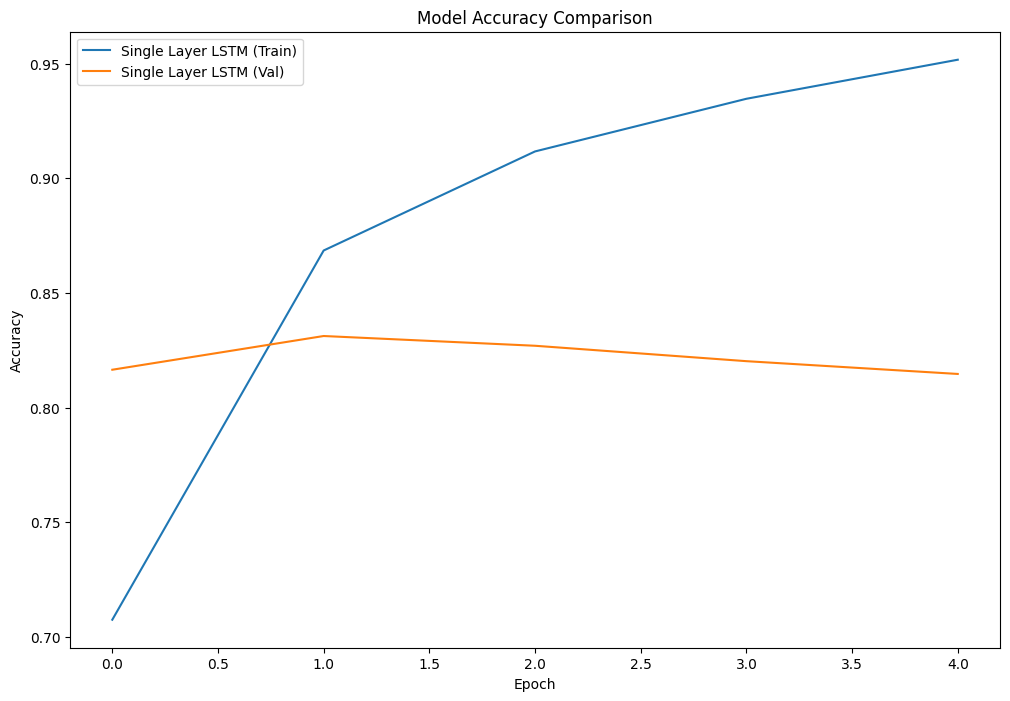

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_single_layer_lstm(vocab_size, embedding_dim=100, input_length=12, num_classes=8):
    """
    Create a single-layer LSTM model.
    
    Args:
        vocab_size: Size of the vocabulary
        embedding_dim: Dimension of word embeddings
        input_length: Length of input sequences
        num_classes: Number of output classes
    """
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size,
                 output_dim=embedding_dim,
                 input_length=input_length),
        
        # Single LSTM layer
        LSTM(units=128,
             activation='tanh',
             recurrent_activation='sigmoid',
             dropout=0.3,
             recurrent_dropout=0.2),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Create all models
vocab_size = embedding_data['vocab_size']
num_classes = len(np.unique(y_train))

# Initialize models
single_lstm = create_single_layer_lstm(vocab_size, num_classes=num_classes)

# Print model summaries
models = {
    'Single Layer LSTM': single_lstm
}

for name, model in models.items():
    print(f"\n{name} Architecture:")
    model.summary()

# Training parameters
train_params = {
    'batch_size': 32,
    'epochs': 20,
    'validation_split': 0.2
}

# Dictionary to store training histories
histories = {}

# Train all models
for name, model in models.items():
    print(f"\nTraining {name}...")
    checkpoint = ModelCheckpoint(
        f'{name.lower().replace(" ", "_")}_best.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
    
    history = model.fit(
        X_train,
        y_train,
        **train_params,
        callbacks=[early_stopping, checkpoint]
    )
    histories[name] = history.history

# Plot training histories
plt.figure(figsize=(12, 8))
for name, history in histories.items():
    plt.plot(history['accuracy'], label=f'{name} (Train)')
    plt.plot(history['val_accuracy'], label=f'{name} (Val)')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### **LSTM (Double layer)**


Double Layer LSTM Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training Double Layer LSTM...
Epoch 1/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 122s 54ms/step - accuracy: 0.5792 - loss: 1.1288 - val_accuracy: 0.8167 - val_loss: 0.5618
Epoch 2/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 117s 54ms/step - accuracy: 0.8697 - loss: 0.4074 - val_accuracy: 0.8240 - val_loss: 0.5415
Epoch 3/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 117s 54ms/step - accuracy: 0.9126 - loss: 0.2712 - val_accuracy: 0.8188 - val_loss: 0.5837
Epoch 4/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 118s 54ms/step - accuracy: 0.9365 - loss: 0.2022 - val_accuracy: 0.8200 - val_loss: 0.6085
Epoch 5/20
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 117s 54ms/step - accuracy: 0.9506 - loss: 0.1572 - val_accuracy: 0.8108 - val_loss: 0.6780


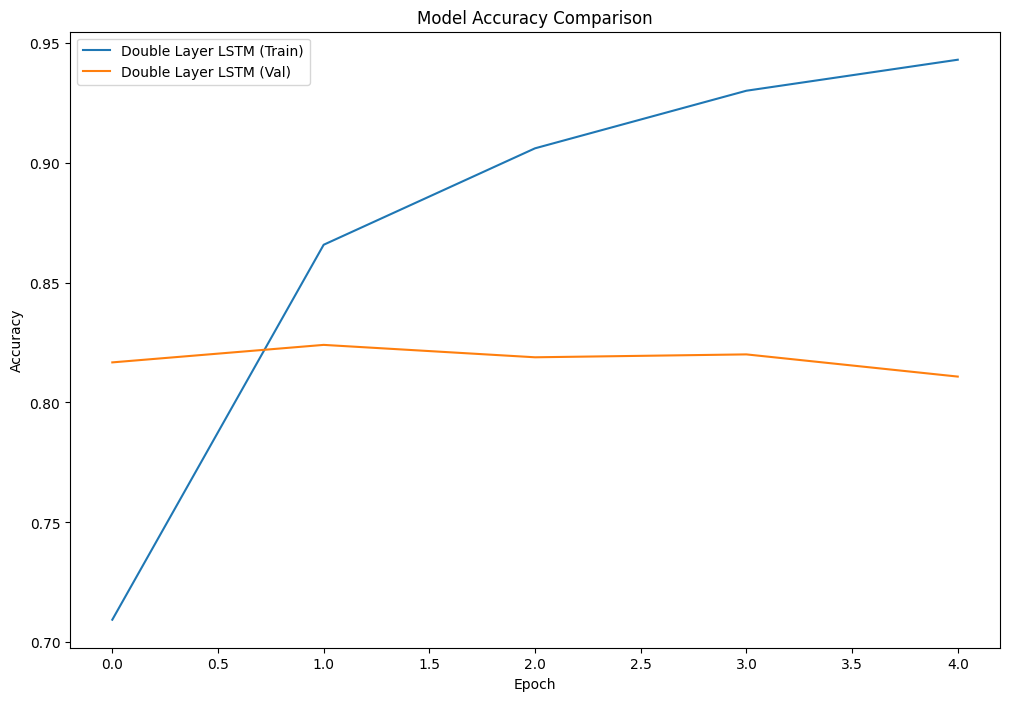

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_double_layer_lstm(vocab_size, embedding_dim=100, input_length=12, num_classes=8):
    """
    Create a Double-layer LSTM model.
    
    Args:
        vocab_size: Size of the vocabulary
        embedding_dim: Dimension of word embeddings
        input_length: Length of input sequences
        num_classes: Number of output classes
    """
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size,
                 output_dim=embedding_dim,
                 input_length=input_length),
        
        # First LSTM layer
        LSTM(units=128,
             activation='tanh',
             recurrent_activation='sigmoid',
             dropout=0.3,
             recurrent_dropout=0.2,
             return_sequences=True),
        
        # Second LSTM layer
        LSTM(units=64,
             activation='tanh',
             recurrent_activation='sigmoid',
             dropout=0.3,
             recurrent_dropout=0.2),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Create all models
vocab_size = embedding_data['vocab_size']
num_classes = len(np.unique(y_train))

# Initialize models
double_lstm = create_double_layer_lstm(vocab_size, num_classes=num_classes)

# Print model summaries
models = {
    'Double Layer LSTM': double_lstm
}

for name, model in models.items():
    print(f"\n{name} Architecture:")
    model.summary()

# Training parameters
train_params = {
    'batch_size': 32,
    'epochs': 20,
    'validation_split': 0.2
}

# Dictionary to store training histories
histories = {}

# Train all models
for name, model in models.items():
    print(f"\nTraining {name}...")
    checkpoint = ModelCheckpoint(
        f'{name.lower().replace(" ", "_")}_best.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
    
    history = model.fit(
        X_train,
        y_train,
        **train_params,
        callbacks=[early_stopping, checkpoint]
    )
    histories[name] = history.history

# Plot training histories
plt.figure(figsize=(12, 8))
for name, history in histories.items():
    plt.plot(history['accuracy'], label=f'{name} (Train)')
    plt.plot(history['val_accuracy'], label=f'{name} (Val)')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## **Model Evaluation**

### **RNN (1/3 Layer)**

680/680 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

=== Evaluation Metrics for Single Layer RNN ===

Overall Accuracy: 0.7845

Per-Class Metrics:
       Class   Precision      Recall    F1-Score     Support
    BUSINESS       0.827       0.780       0.803        3000
ENTERTAINMENT       0.891       0.824       0.857        3000
      HEALTH       0.779       0.790       0.785        3000
      NATION       0.607       0.724       0.660        3000
     SCIENCE       0.758       0.836       0.795         755
      SPORTS       0.928       0.908       0.918        3000
  TECHNOLOGY       0.889       0.870       0.879        3000
       WORLD       0.617       0.582       0.599        3000

Aggregate Metrics:
macro avg:
  Precision: 0.787
  Recall: 0.789
  F1-Score: 0.787
weighted avg:
  Precision: 0.790
  Recall: 0.784
  F1-Score: 0.786

=== Evaluation Metrics for Three Layer RNN ===

Overall Accuracy: 0.4885

Per-Class Metrics:
       Class   Precision    

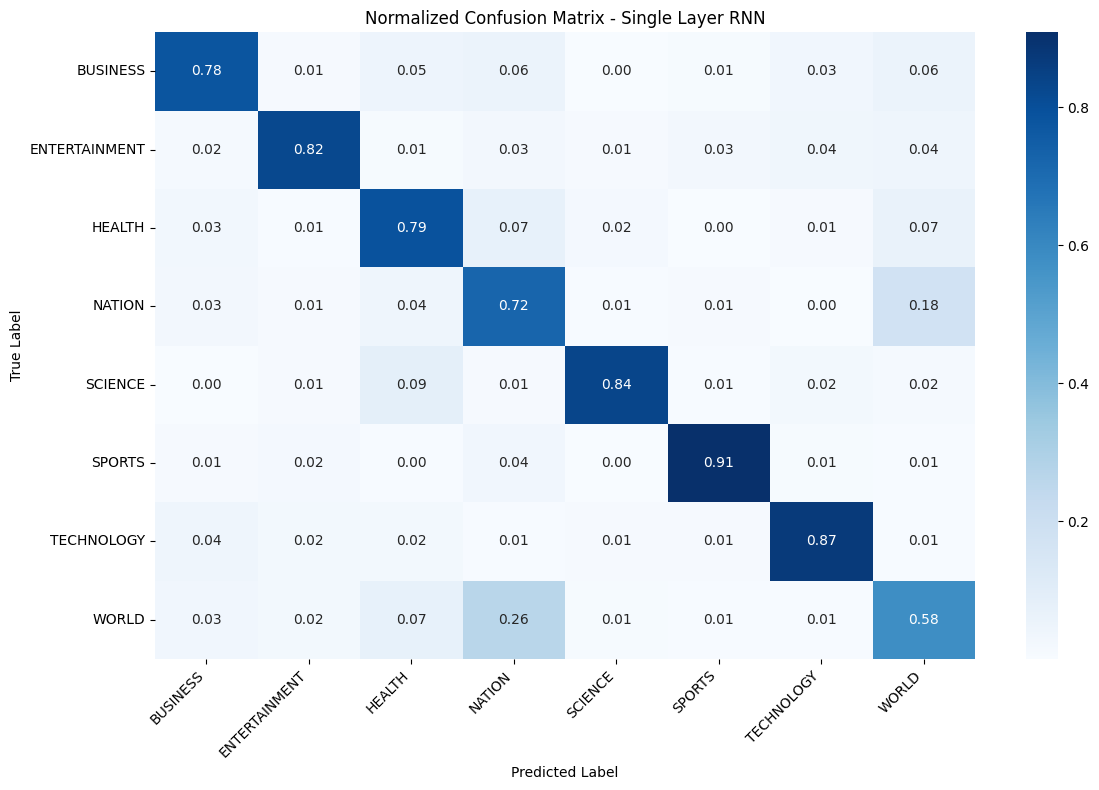

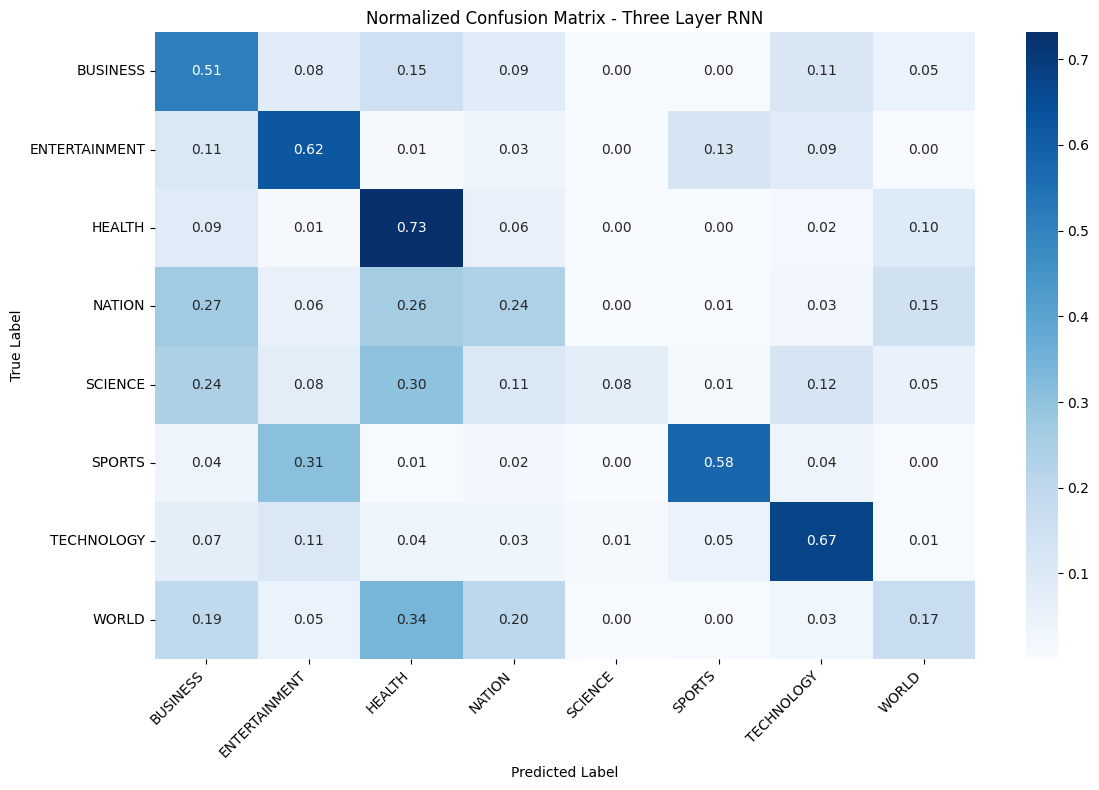

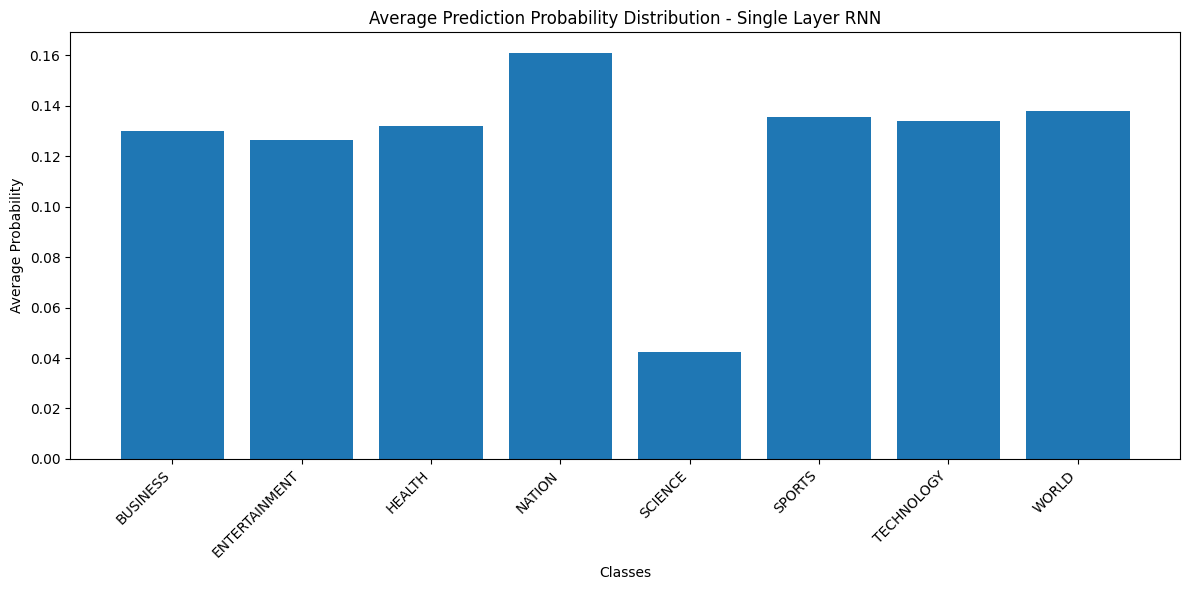

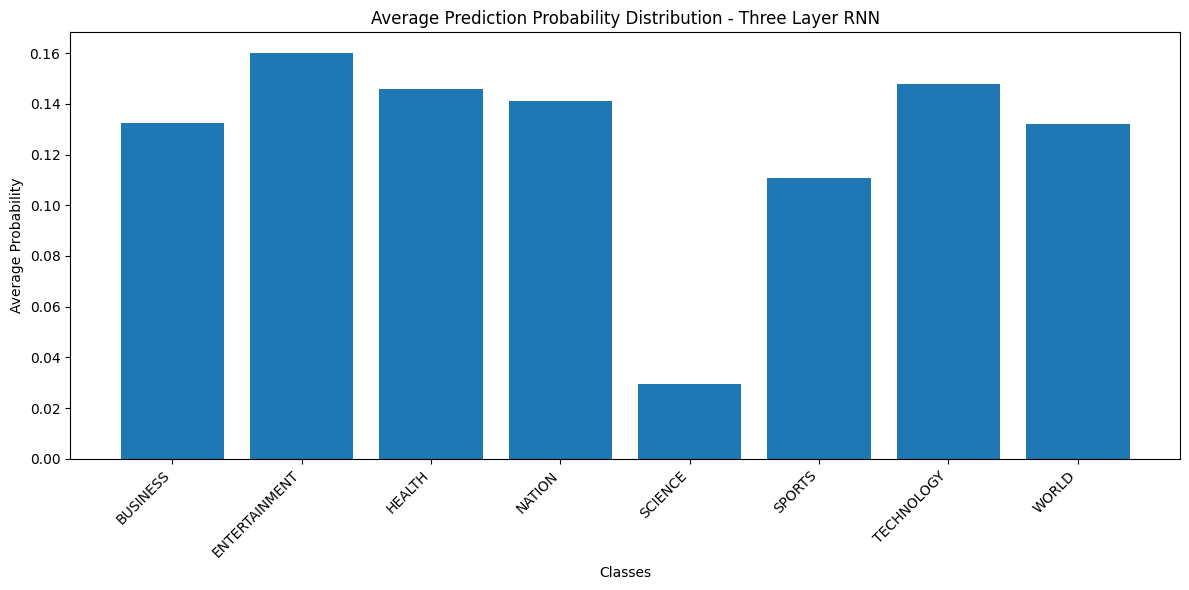

In [28]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def evaluate_rnn_model(model, X_test, y_test, class_names, model_name="RNN Model"):
    """
    Evaluate RNN model performance with multiple metrics.
    
    Args:
        model: Trained Keras model
        X_test: Test features
        y_test: True labels
        class_names: Names of the classes
        model_name: Name of the model for display
    
    Returns:
        dict: Dictionary containing all evaluation metrics
    """
    # Get predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Get detailed classification report
    report = classification_report(y_test, y_pred, 
                                 target_names=class_names, 
                                 output_dict=True)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create confusion matrix plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.2f', 
                xticklabels=class_names,
                yticklabels=class_names,
                cmap='Blues')
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Store results
    evaluation_results = {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'confusion_matrix_normalized': cm_normalized,
        'predictions': y_pred,
        'prediction_probabilities': y_pred_probs
    }
    
    return evaluation_results

def plot_prediction_distribution(y_pred_probs, class_names, model_name="RNN Model"):
    """
    Plot distribution of prediction probabilities.
    
    Args:
        y_pred_probs: Prediction probabilities from model
        class_names: Names of the classes
        model_name: Name of the model for display
    """
    plt.figure(figsize=(12, 6))
    
    # Calculate average prediction probability for each class
    avg_probs = np.mean(y_pred_probs, axis=0)
    
    # Create bar plot
    plt.bar(class_names, avg_probs)
    plt.title(f'Average Prediction Probability Distribution - {model_name}')
    plt.xlabel('Classes')
    plt.ylabel('Average Probability')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

def display_evaluation_metrics(eval_results, model_name="RNN Model"):
    """
    Display all evaluation metrics in a formatted way.
    
    Args:
        eval_results: Dictionary containing evaluation metrics
        model_name: Name of the model for display
    """
    print(f"\n=== Evaluation Metrics for {model_name} ===")
    print(f"\nOverall Accuracy: {eval_results['accuracy']:.4f}")
    
    # Display classification report metrics
    report = eval_results['classification_report']
    
    print("\nPer-Class Metrics:")
    headers = ['Precision', 'Recall', 'F1-Score', 'Support']
    row_format = "{:>12}" * (len(headers) + 1)
    print(row_format.format("Class", *headers))
    
    for class_name in report.keys():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics = report[class_name]
            print(row_format.format(
                class_name,
                f"{metrics['precision']:.3f}",
                f"{metrics['recall']:.3f}",
                f"{metrics['f1-score']:.3f}",
                f"{metrics['support']}"
            ))
    
    print("\nAggregate Metrics:")
    for avg_type in ['macro avg', 'weighted avg']:
        metrics = report[avg_type]
        print(f"{avg_type}:")
        print(f"  Precision: {metrics['precision']:.3f}")
        print(f"  Recall: {metrics['recall']:.3f}")
        print(f"  F1-Score: {metrics['f1-score']:.3f}")

# Evaluate both models
class_names = embedding_data['label_encoder'].classes_

# For single layer model
single_layer_eval = evaluate_rnn_model(
    single_layer_model,
    X_test,
    y_test,
    class_names,
    "Single Layer RNN"
)

# For three layer model
three_layer_eval = evaluate_rnn_model(
    three_layer_model,
    X_test,
    y_test,
    class_names,
    "Three Layer RNN"
)

# Display metrics for both models
display_evaluation_metrics(single_layer_eval, "Single Layer RNN")
display_evaluation_metrics(three_layer_eval, "Three Layer RNN")

# Plot prediction distributions
plot_prediction_distribution(
    single_layer_eval['prediction_probabilities'],
    class_names,
    "Single Layer RNN"
)
plot_prediction_distribution(
    three_layer_eval['prediction_probabilities'],
    class_names,
    "Three Layer RNN"
)
plt.show()

### **Comments**
From the RNN Heat maps, we can gather something very interesting. While the single layer RNN is quite capable, as well as putting forth quite valid results, We can see at the same time that the 3 layer RNN has started to confuse the topics, and is misclassifying a lot of the topics as Health, even though they might not be.

We can also see the same effect in the bar graphs where for single layer, all the topics average out around 0.15 probability of being predicted (except science), but in the 3 layer RNN, Health comes out over 0.175, while the rest lie below 0.15. This shows that a lot of the predictions had shifted to the health topic. 

Now, although this is complete assumtions based on my viewings of the data, I can see some reasons why this might be:-

1. Health is a very wide field, and due to that it encompasses topics like World, Nation, Science, Business, and of Health too. This then contributes to the fact that when trained to identify who wuld belong where, the RNN might classify the science or world news as health news as well (imagine science news about developments in the *Biology* field would lend to health, or World news about maybe *COVID-19* might also get classified under health.)

2. As we increase the layers of RNNs, what we are basically doing are retraining the weights on already trained weights. Meaning, we are basically amplifying the errors and weights of the first layer onto the second and so on and so forth. this might lead to a better model, but due to a small amount of data (100K Documents resulting in 65K unique words doesn't necessarily constitute for very complex relations between the words that warrant 3 Neural network layers.)

### **LSTM (Single Layer)**

680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


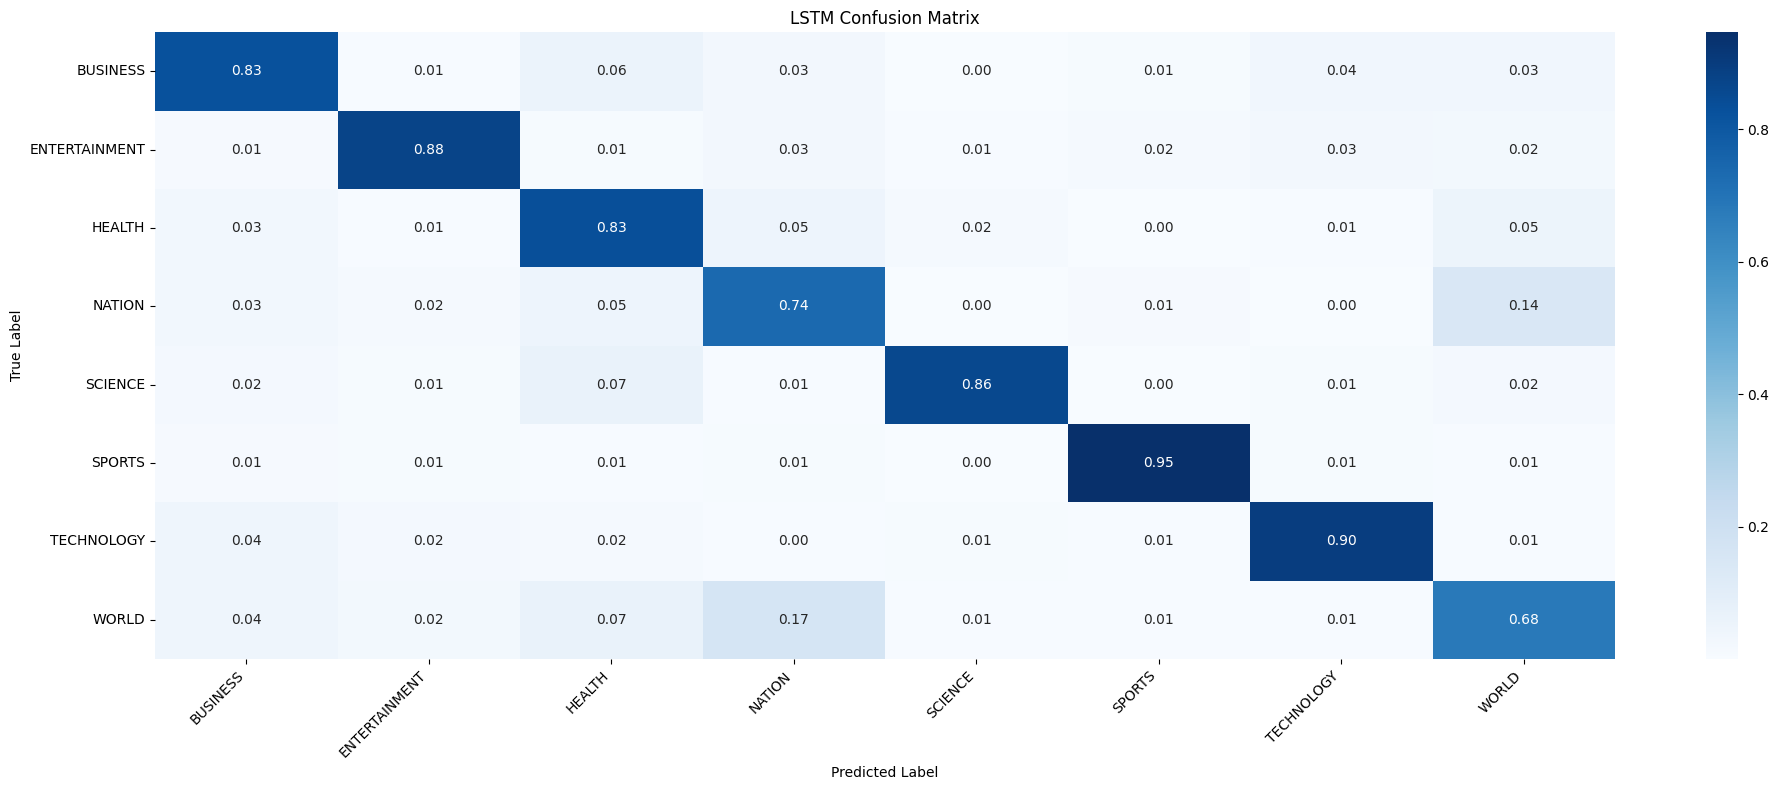

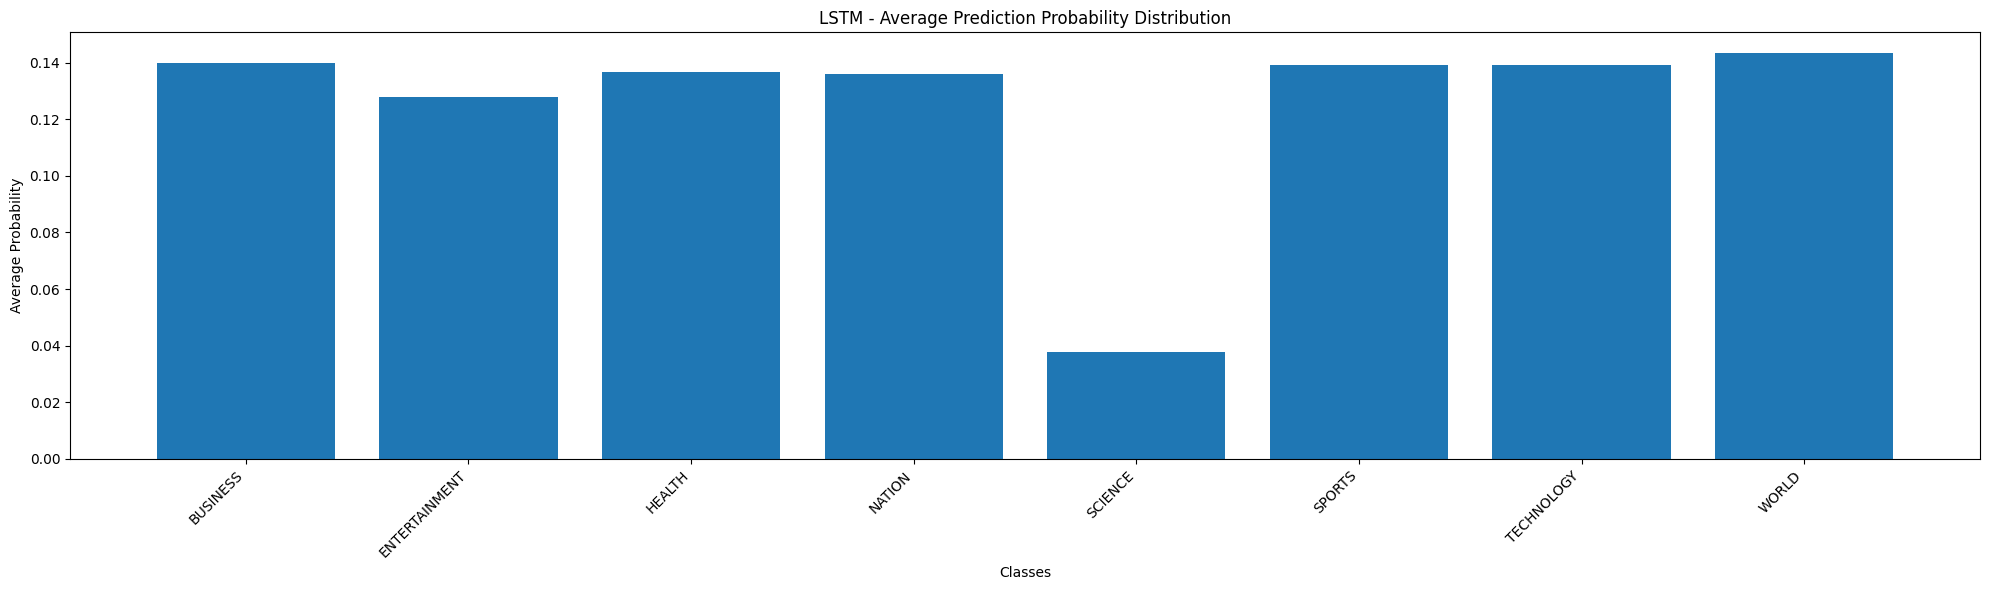


=== Overall Accuracy Comparison ===
LSTM Accuracy: 0.8291

=== Per-Class Performance Comparison ===

LSTM Metrics:
       Class   Precision      Recall    F1-Score
    BUSINESS       0.821       0.827       0.824
ENTERTAINMENT       0.912       0.875       0.893
      HEALTH       0.786       0.835       0.810
      NATION       0.719       0.736       0.727
     SCIENCE       0.841       0.861       0.851
      SPORTS       0.944       0.947       0.945
  TECHNOLOGY       0.908       0.896       0.902
       WORLD       0.714       0.681       0.697

=== Aggregate Metrics Comparison ===

macro avg:
                   LSTM
precision         0.831 
recall            0.832 
f1-score          0.831 

weighted avg:
                   LSTM
precision         0.830 
recall            0.829 
f1-score          0.829 


In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def LSTM_model_eval(lstm_model, X_test, y_test, class_names):

    # Get predictions from both models
    lstm_pred_probs = lstm_model.predict(X_test)
    
    lstm_pred = np.argmax(lstm_pred_probs, axis=1)
    
    # Calculate metrics for both models
    metrics = {
        'LSTM': {
            'accuracy': accuracy_score(y_test, lstm_pred),
            'report': classification_report(y_test, lstm_pred, 
                                         target_names=class_names, 
                                         output_dict=True),
            'cm': confusion_matrix(y_test, lstm_pred),
            'pred_probs': lstm_pred_probs
        }
    }
    
    # Plot confusion matrices side by side
    fig, ax1 = plt.subplots(1, figsize=(20, 8))
    
    # LSTM confusion matrix
    cm_lstm_norm = metrics['LSTM']['cm'].astype('float') / metrics['LSTM']['cm'].sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_lstm_norm, annot=True, fmt='.2f', 
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues', ax=ax1)
    ax1.set_title('LSTM Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Plot prediction probability distributions
    fig, ax1 = plt.subplots(1, figsize=(20, 6))
    
    # LSTM probabilities
    avg_probs_lstm = np.mean(metrics['LSTM']['pred_probs'], axis=0)
    ax1.bar(class_names, avg_probs_lstm)
    ax1.set_title('LSTM - Average Prediction Probability Distribution')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Average Probability')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    
    plt.tight_layout()
    plt.show()
    
    return metrics

def display_comparative_metrics(metrics):

    # Print overall accuracy comparison
    print("\n=== Overall Accuracy Comparison ===")
    print(f"LSTM Accuracy: {metrics['LSTM']['accuracy']:.4f}")
    
    # Print per-class metrics comparison
    print("\n=== Per-Class Performance Comparison ===")
    headers = ['Precision', 'Recall', 'F1-Score']
    row_format = "{:>12}" * (len(headers) + 1)
    
    for model_name in ['LSTM']:
        print(f"\n{model_name} Metrics:")
        print(row_format.format("Class", *headers))
        
        report = metrics[model_name]['report']
        for class_name in report.keys():
            if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                m = report[class_name]
                print(row_format.format(
                    class_name,
                    f"{m['precision']:.3f}",
                    f"{m['recall']:.3f}",
                    f"{m['f1-score']:.3f}"
                ))
    
    # Print aggregate metrics comparison
    print("\n=== Aggregate Metrics Comparison ===")
    for avg_type in ['macro avg', 'weighted avg']:
        print(f"\n{avg_type}:")
        lstm_metrics = metrics['LSTM']['report'][avg_type]
        
        print(f"{'':12} {'LSTM':>10}")
        for metric in ['precision', 'recall', 'f1-score']:
            lstm_value = lstm_metrics[metric]
            print(f"{metric:12} {lstm_value:10.3f} ")

# Get class names from label encoder
class_names = embedding_data['label_encoder'].classes_

# Compare models
comparison_metrics = LSTM_model_eval(
    single_lstm,
    X_test,
    y_test,
    class_names
)

# Display detailed metrics
display_comparative_metrics(comparison_metrics)


### **LSTM (Double Layer)**

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


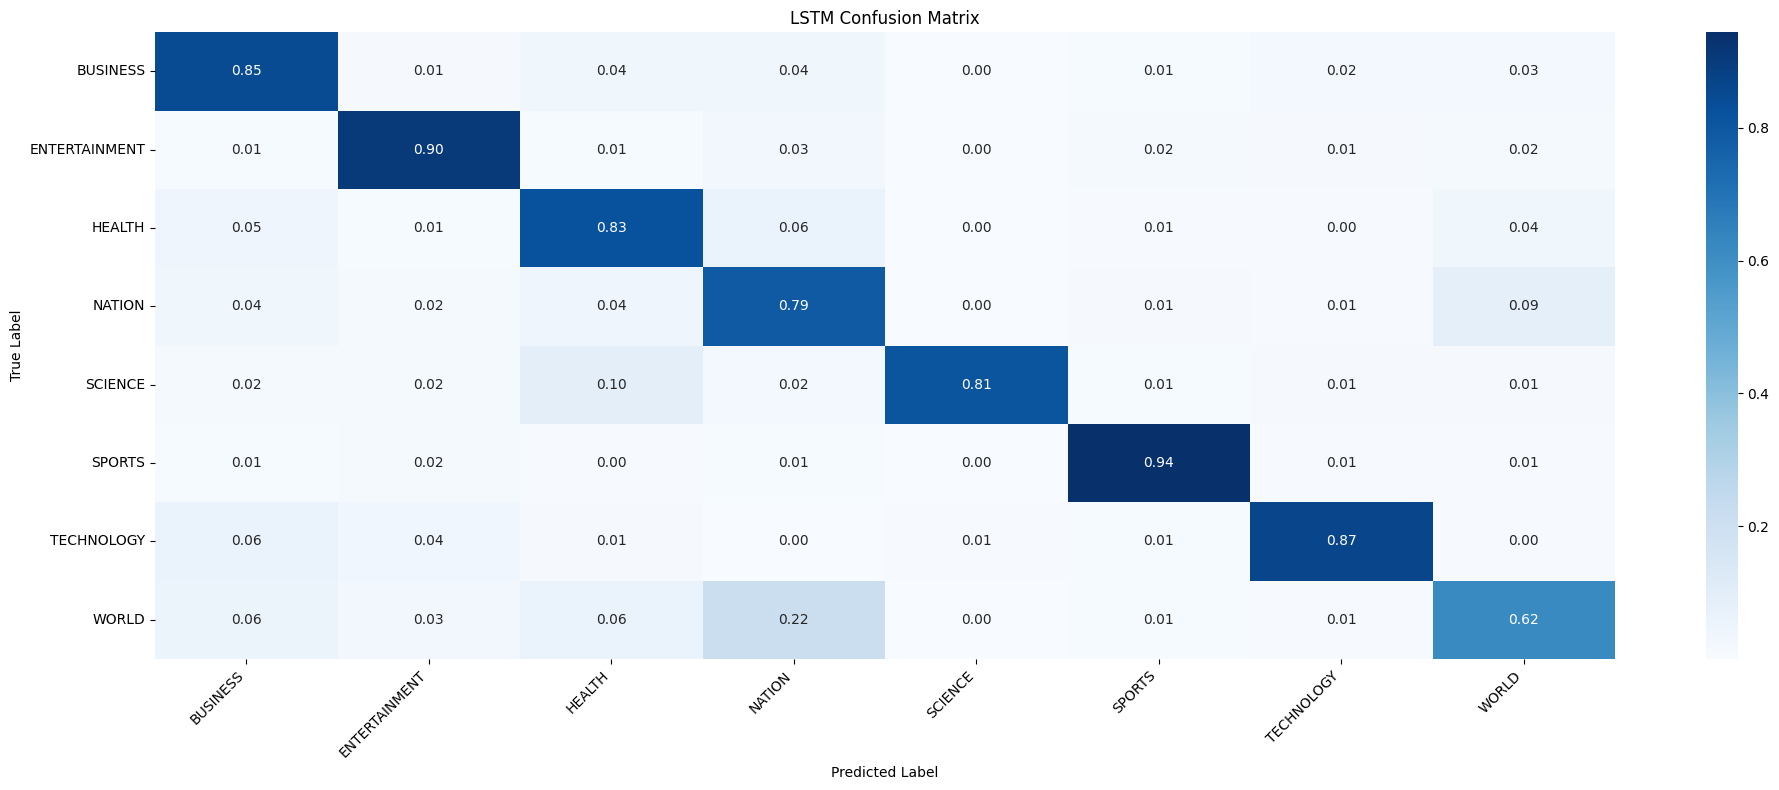

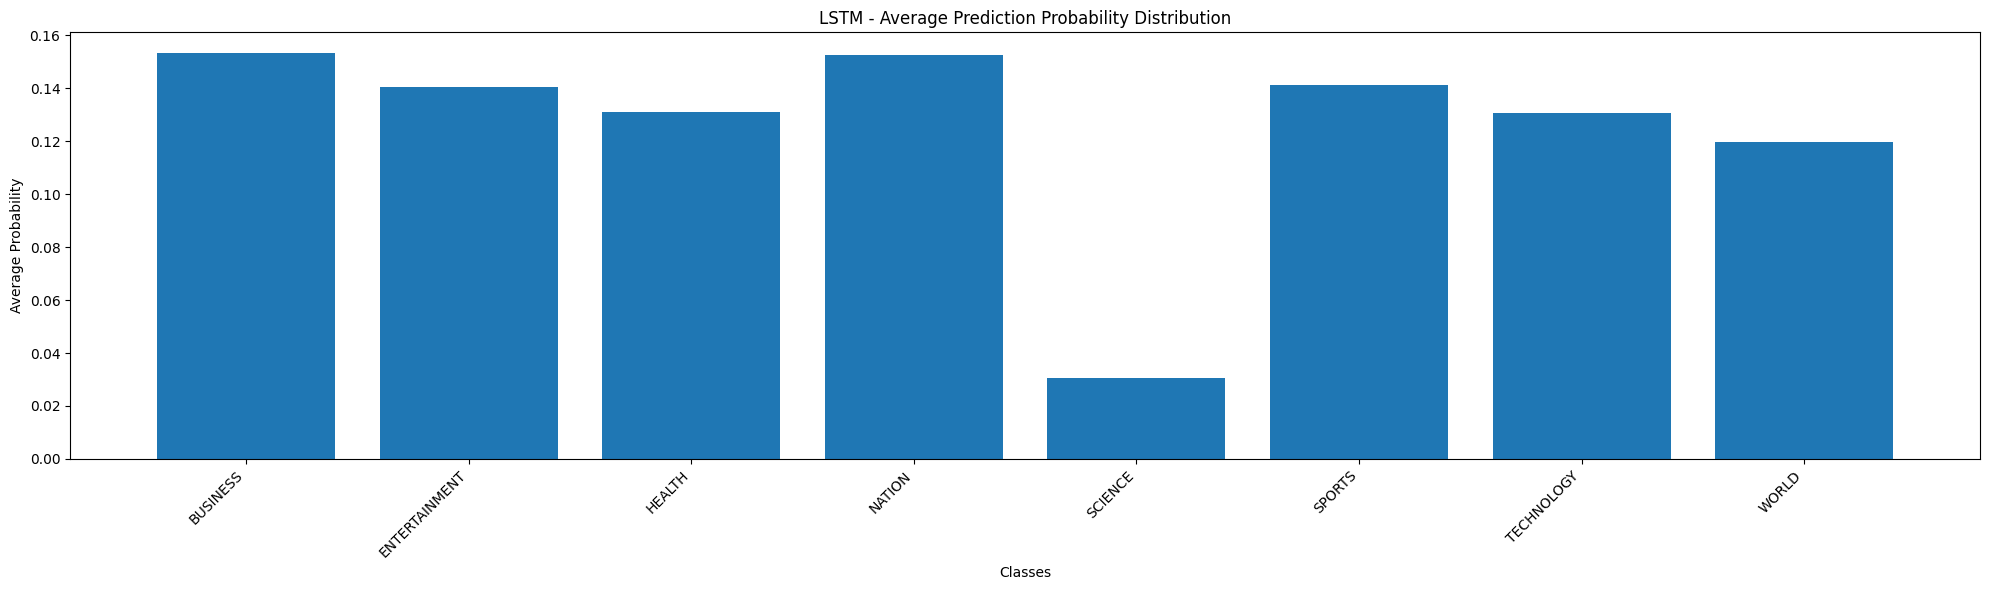


=== Overall Accuracy Comparison ===
LSTM Accuracy: 0.8270

=== Per-Class Performance Comparison ===

LSTM Metrics:
       Class   Precision      Recall    F1-Score
    BUSINESS       0.785       0.847       0.815
ENTERTAINMENT       0.873       0.904       0.888
      HEALTH       0.810       0.826       0.818
      NATION       0.684       0.789       0.732
     SCIENCE       0.927       0.809       0.864
      SPORTS       0.933       0.944       0.939
  TECHNOLOGY       0.930       0.867       0.897
       WORLD       0.771       0.618       0.686

=== Aggregate Metrics Comparison ===

macro avg:
                   LSTM
precision         0.839 
recall            0.825 
f1-score          0.830 

weighted avg:
                   LSTM
precision         0.830 
recall            0.827 
f1-score          0.826 


In [30]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def LSTM_model_eval(lstm_model, X_test, y_test, class_names):

    # Get predictions from both models
    lstm_pred_probs = lstm_model.predict(X_test)
    
    lstm_pred = np.argmax(lstm_pred_probs, axis=1)
    
    # Calculate metrics for both models
    metrics = {
        'LSTM': {
            'accuracy': accuracy_score(y_test, lstm_pred),
            'report': classification_report(y_test, lstm_pred, 
                                         target_names=class_names, 
                                         output_dict=True),
            'cm': confusion_matrix(y_test, lstm_pred),
            'pred_probs': lstm_pred_probs
        }
    }
    
    # Plot confusion matrices side by side
    fig, ax1 = plt.subplots(1, figsize=(20, 8))
    
    # LSTM confusion matrix
    cm_lstm_norm = metrics['LSTM']['cm'].astype('float') / metrics['LSTM']['cm'].sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_lstm_norm, annot=True, fmt='.2f', 
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues', ax=ax1)
    ax1.set_title('LSTM Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Plot prediction probability distributions
    fig, ax1 = plt.subplots(1, figsize=(20, 6))
    
    # LSTM probabilities
    avg_probs_lstm = np.mean(metrics['LSTM']['pred_probs'], axis=0)
    ax1.bar(class_names, avg_probs_lstm)
    ax1.set_title('LSTM - Average Prediction Probability Distribution')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Average Probability')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    
    plt.tight_layout()
    plt.show()
    
    return metrics

def display_comparative_metrics(metrics):

    # Print overall accuracy comparison
    print("\n=== Overall Accuracy Comparison ===")
    print(f"LSTM Accuracy: {metrics['LSTM']['accuracy']:.4f}")
    
    # Print per-class metrics comparison
    print("\n=== Per-Class Performance Comparison ===")
    headers = ['Precision', 'Recall', 'F1-Score']
    row_format = "{:>12}" * (len(headers) + 1)
    
    for model_name in ['LSTM']:
        print(f"\n{model_name} Metrics:")
        print(row_format.format("Class", *headers))
        
        report = metrics[model_name]['report']
        for class_name in report.keys():
            if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                m = report[class_name]
                print(row_format.format(
                    class_name,
                    f"{m['precision']:.3f}",
                    f"{m['recall']:.3f}",
                    f"{m['f1-score']:.3f}"
                ))
    
    # Print aggregate metrics comparison
    print("\n=== Aggregate Metrics Comparison ===")
    for avg_type in ['macro avg', 'weighted avg']:
        print(f"\n{avg_type}:")
        lstm_metrics = metrics['LSTM']['report'][avg_type]
        
        print(f"{'':12} {'LSTM':>10}")
        for metric in ['precision', 'recall', 'f1-score']:
            lstm_value = lstm_metrics[metric]
            print(f"{metric:12} {lstm_value:10.3f} ")

# Get class names from label encoder
class_names = embedding_data['label_encoder'].classes_

# Compare models
comparison_metrics = LSTM_model_eval(
    double_lstm,
    X_test,
    y_test,
    class_names
)

# Display detailed metrics
display_comparative_metrics(comparison_metrics)


|RNN|LSTM|LSTM (2 Layer)|
|---|---|---|
| 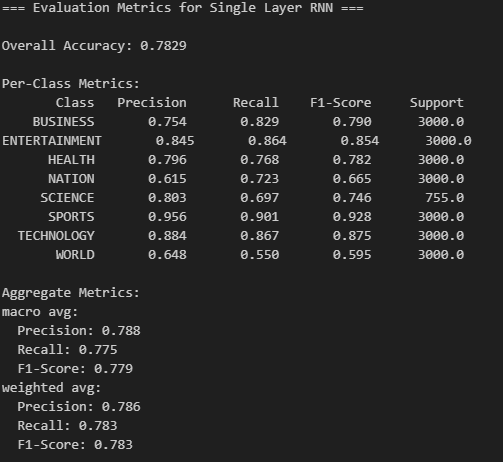|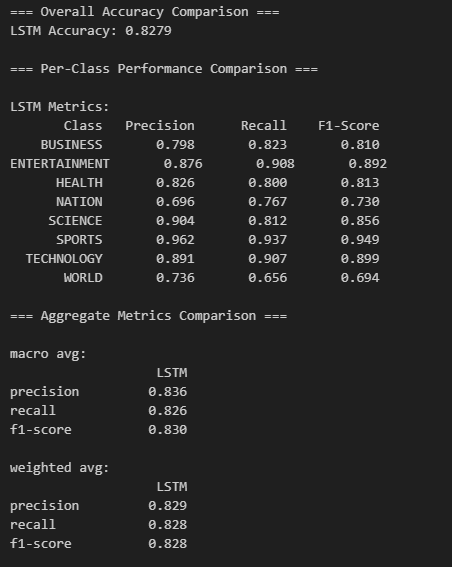|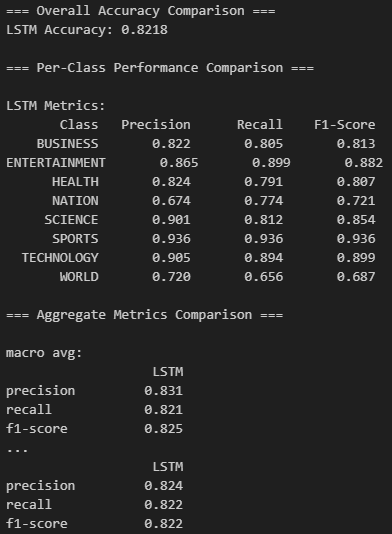|

### **Comments** (Pt. 2 - Electric Boogaloo)
From the LSTM and RNN metrics, we can show that LSTMs do a better job than RNNs in general. with an overall accuracy of 82% over the 78% accuracy of the RNN, we can conclude that in general, LSTMs are better.

We can also see some other places where LSTMs outshine RNNs such as 
1. The Per-Class metrics are better for LSTMs in every class and metric.
2. The weighted avg & macro avg metrics are both better for LSTMs rather than RNNs.

According to my observations, these advantages can be attributed to the architecture of LSTMs that allow it to store more context than teh more localized RNNs, especially for classification. While training, I passed a vector of length 12, and that is the title of the news article. That would result in high contextual clues across the title that might be lost on the RNN, but picked up by the LSTM.